In [1]:
import cv2 as cv
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

In [13]:
img = cv.imread("dataset/sardor_abdirayimov/5.png")
# opencv BGR channel format and plt reads images as RGB channel format

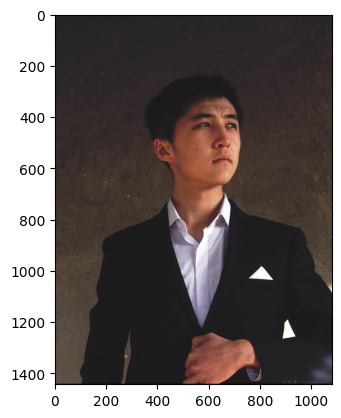

In [15]:
img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
plt.imshow(img) # RGBy

## MTCNN or Multi-Task Cascaded Convolutional Neural Networks is a neural network which detects faces and facial landmarks on images.

In [16]:
from mtcnn.mtcnn import MTCNN

detector = MTCNN()
results = detector.detect_faces(img)

face_index = []

face = detector(312, 468, 48, 219)
if face not in face_index:
    print(face)

else:
    print("Available in face")

1/1 [==============================] - 0s 129ms/step


In [17]:
results

[{'box': [463, 307, 259, 353],
  'confidence': 0.9999786615371704,
  'keypoints': {'left_eye': (581, 433),
   'right_eye': (684, 432),
   'nose': (669, 493),
   'mouth_left': (611, 577),
   'mouth_right': (683, 573)}}]

In [18]:
x,y,w,h = results[0]['box']

cv.rectangle: This is a function from the OpenCV library used to draw rectangles on images.

img: This is the image on which the rectangle will be drawn.

(x,y): These are the coordinates of the top-left corner of the rectangle. x is the distance from the left edge of the image, and y is the distance from the top edge of the image.

(x+w, y+h): These are the coordinates of the bottom-right corner of the rectangle. x+w is the distance from the left edge of the image to the right edge of the rectangle, and y+h is the distance from the top edge of the image to the bottom edge of the rectangle. w is the width of the rectangle, and h is the height of the rectangle.

(0,0,255): This is the color of the rectangle in BGR format. In this case, it's red because the third value is 255 (blue and green are both set to 0).

This is the thickness of the rectangle's outline in pixels. In this case, it's 5 pixels thick.

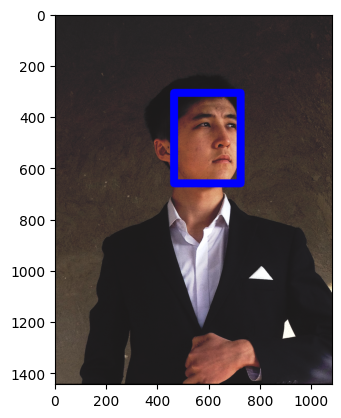

In [21]:
img = cv.rectangle(img, (x,y), (x+w, y+h), (0,0,255), 5)
plt.imshow(img)

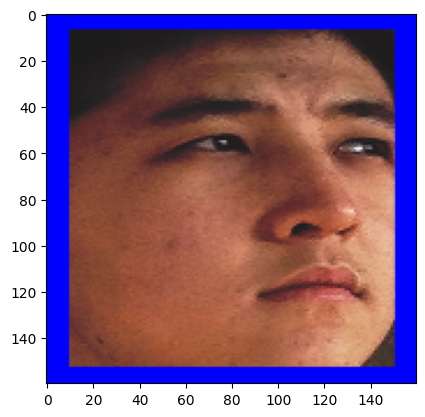

In [24]:
my_face = img[y:y+h, x:x+w]
#Facenet takes as input 160x160 
my_face = cv.resize(my_face, (160, 160))
plt.imshow(my_face)

# Auto Preprocessing images

In [30]:
class FACELOADING:
    def __init__(self, directory):
        self.directory = directory
        self.target_size = (160,160)
        self.X = []
        self.Y = []
        self.detector = MTCNN()
    

    def extract_face(self, filename):
        img = cv.imread(filename)
        img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
        x,y,w,h = self.detector.detect_faces(img)[0]['box']
        x,y = abs(x), abs(y)
        face = img[y:y+h, x:x+w]
        face_arr = cv.resize(face, self.target_size)
        return face_arr
    

    def load_faces(self, dir):
        FACES = []
        for im_name in os.listdir(dir):
            try:
                path = dir + im_name
                single_face = self.extract_face(path)
                FACES.append(single_face)
            except Exception as e:
                pass
        return FACES

    def load_classes(self):
        for sub_dir in os.listdir(self.directory):
            path = self.directory +'/'+ sub_dir+'/'
            FACES = self.load_faces(path)
            labels = [sub_dir for _ in range(len(FACES))]
            print(f"Loaded successfully: {len(labels)}")
            self.X.extend(FACES)
            self.Y.extend(labels)
        
        return np.asarray(self.X), np.asarray(self.Y)


    def plot_images(self):
        plt.figure(figsize=(18,16))
        for num,image in enumerate(self.X):
            ncols = 3
            nrows = len(self.Y)//ncols + 1
            plt.subplot(nrows,ncols,num+1)
            plt.imshow(image)
            plt.axis('off')

In [31]:
faceloading = FACELOADING("dataset")
X, Y = faceloading.load_classes()

2/2 [==============================] - 0s 11ms/step
Loaded successfully: 10
1/1 [==============================] - 0s 26ms/step
Loaded successfully: 10
1/1 [==============================] - 0s 26ms/step
Loaded successfully: 10
1/1 [==============================] - 0s 25ms/step
Loaded successfully: 10


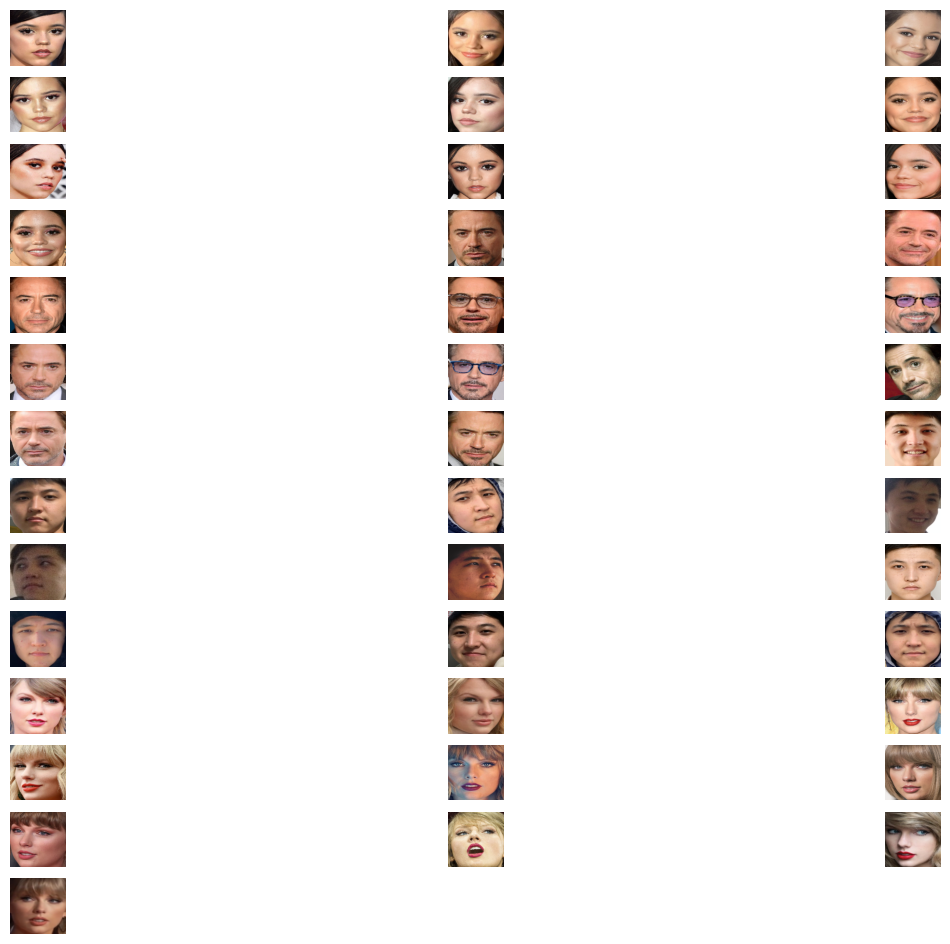

In [32]:
plt.figure(figsize=(16,12))
for num,image in enumerate(X):
    ncols = 3
    nrows = len(Y)//ncols + 1
    plt.subplot(nrows,ncols,num+1)
    plt.imshow(image)
    plt.axis('off')

In [36]:
from keras_facenet import FaceNet
embedder = FaceNet()

def get_embedding(face_img):
    face_img = face_img.astype('float32') # 3D(160x160x3)
    face_img = np.expand_dims(face_img, axis=0) 
    # 4D (Nonex160x160x3)
    yhat= embedder.embeddings(face_img)
    return yhat[0] # 512D image (1x1x512)

In [38]:
EMBEDDED_X = []

for img in X:
    EMBEDDED_X.append(get_embedding(img))

EMBEDDED_X = np.asarray(EMBEDDED_X)

1/1 [==============================] - 0s 61ms/step


In [40]:
np.savez_compressed('faces_embeddings_done_4classes.npz', EMBEDDED_X, Y)

In [47]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
encoder.fit(Y)
Y = encoder.transform(Y)

In [48]:
Y

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3])

Text(0, 0.5, '0')

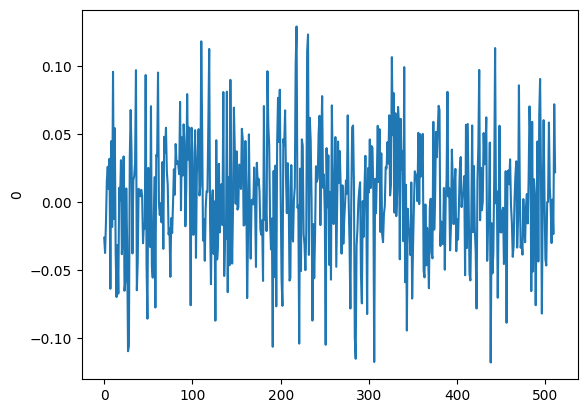

In [49]:
plt.plot(EMBEDDED_X[0]) 
plt.ylabel(Y[0])

In [50]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
X_train, X_test, Y_train, Y_test = train_test_split(EMBEDDED_X, Y, shuffle=True, random_state=17)


model = SVC(kernel='linear', probability=True)
model.fit(X_train, Y_train)

SVC(kernel='linear', probability=True)

In [51]:
ypreds_train = model.predict(X_train)
ypreds_test = model.predict(X_test)

In [52]:
ypreds_test

array([3, 1, 1, 3, 2, 3, 1, 2, 0, 2])

In [53]:
from sklearn.metrics import accuracy_score

accuracy_score(Y_train, ypreds_train)

1.0

In [54]:
accuracy_score(Y_test,ypreds_test)

1.0

In [59]:
t_im = cv.imread("sardor_test.jpg")
t_im = cv.cvtColor(t_im, cv.COLOR_BGR2RGB)
x,y,w,h = detector.detect_faces(t_im)[0]['box']

1/1 [==============================] - 0s 26ms/step


In [60]:
t_im = t_im[y:y+h, x:x+w]
t_im = cv.resize(t_im, (160,160))
test_im = get_embedding(t_im)

1/1 [==============================] - 0s 66ms/step


In [61]:
test_im = [test_im]
ypreds = model.predict(test_im)

In [62]:
ypreds

array([2])

In [63]:
encoder.inverse_transform(ypreds)

array(['sardor_abdirayimov'], dtype='<U18')

In [64]:
import pickle
#save the model
with open('svm_model_160x160.pkl','wb') as f:
    pickle.dump(model,f)